In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
matplotlib.rc("font", family = "Malgun Gothic")
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
%matplotlib inline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
matplotlib.rc("font", family = "Malgun Gothic")
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
df_raw = pd.read_csv("HMEQ.csv")
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [3]:
df_raw.isnull().sum()
df_raw["JOB"].fillna("Other", inplace = True)
df_raw.fillna(df_raw.mean(), inplace = True)
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [4]:
df_y = df_raw_dummy["BAD"]
df_x = df_raw_dummy.drop("BAD", axis = 1, inplace = False)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3, random_state = 1234)
print("train data x size: {}".format(df_train_x.shape))
print("train data y size: {}".format(df_train_y.shape))
print("test data x size: {}".format(df_test_x.shape))
print("test data y size: {}".format(df_test_y.shape))

train data x size: (2623, 18)
train data y size: (2623,)
test data x size: (1125, 18)
test data y size: (1125,)


In [5]:
gb_uncustomized = GradientBoostingClassifier(random_state = 1234)
gb_uncustomized.fit(df_train_x, df_train_y)
print("Scoring on training set: {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))
print("Scoring on test set: {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

Scoring on training set: 0.963
Scoring on test set: 0.941


In [8]:
train_accuracy = []; test_accuracy = []
para_lr = [lr*0.1 for lr in range(1, 11)]

for v_learning_rate in para_lr:
    gb = GradientBoostingClassifier(learning_rate = v_learning_rate, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

df_accuracy_lr = pd.DataFrame()
df_accuracy_lr["Learning Rate"] = para_lr
df_accuracy_lr['TrainAccuracy'] = train_accuracy
df_accuracy_lr["TestAccuracy"] = test_accuracy
df_accuracy_lr.round(3)

,Learning Rate,TrainAccuracy,TestAccuracy
0,0.1,0.963,0.941
1,0.2,0.984,0.940
2,0.3,0.994,0.939
3,0.4,0.999,0.944
4,0.5,1.000,0.934
5,0.6,1.000,0.937
6,0.7,1.000,0.941
7,0.8,0.999,0.931
8,0.9,1.000,0.937
9,1.0,0.971,0.924


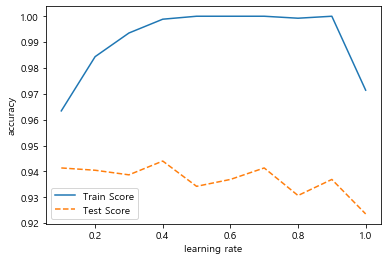

In [9]:
plt.plot(para_lr, train_accuracy, linestyle = "-", label = "Train Score")
plt.plot(para_lr, test_accuracy, linestyle = "--", label = "Test Score")
plt.ylabel("accuracy"); plt.xlabel("learning rate")
plt.legend()

In [10]:
train_accuracy = []; test_accuracy = []
para_n_tree = [n_tree*10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(n_estimators = v_n_estimators, learning_rate = 0.1, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

df_accuracy_n = pd.DataFrame()
df_accuracy_n["n_estimators"] = para_n_tree
df_accuracy_n['TrainAccuracy'] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy
df_accuracy_n.round(3)

,n_estimators,TrainAccuracy,TestAccuracy
0,10,0.933,0.928
1,20,0.939,0.932
2,30,0.947,0.936
3,40,0.952,0.940
4,50,0.956,0.940
5,60,0.957,0.940
6,70,0.957,0.939
7,80,0.960,0.939
8,90,0.961,0.940
9,100,0.963,0.941


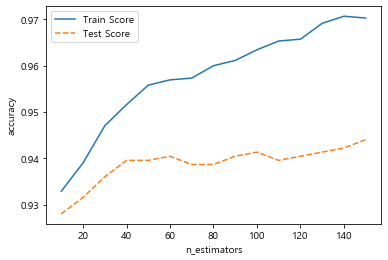

In [11]:
plt.plot(para_n_tree, train_accuracy, linestyle = "-", label = "Train Score")
plt.plot(para_n_tree, test_accuracy, linestyle = "--", label = "Test Score")
plt.ylabel("accuracy"); plt.xlabel("n_estimators")
plt.legend()

In [12]:
train_accuracy = []; test_accuracy = []
para_depth = [depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    gb = GradientBoostingClassifier(max_depth = v_max_depth, n_estimators = 100, learning_rate = 0.1, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth['TrainAccuracy'] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.936,0.935
1,2,0.951,0.940
2,3,0.963,0.941
3,4,0.979,0.945
4,5,0.990,0.941
5,6,0.998,0.949
6,7,1.000,0.946
7,8,1.000,0.948
8,9,1.000,0.949
9,10,1.000,0.946


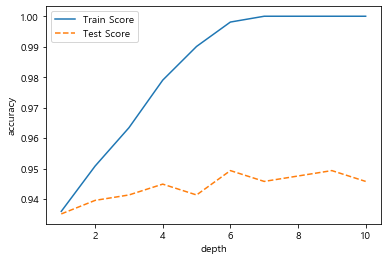

In [14]:
plt.plot(para_depth, train_accuracy, linestyle = "-", label = "Train Score")
plt.plot(para_depth, test_accuracy, linestyle = "--", label = "Test Score")
plt.ylabel("accuracy"); plt.xlabel("depth")
plt.legend()

In [15]:
train_accuracy = []; test_accuracy = []
para_split = [n_split * 10 for n_split in range(1, 11)]

for v_min_samples_split in para_split:
    gb = GradientBoostingClassifier(min_samples_split = v_min_samples_split, max_depth = 4, n_estimators = 100, learning_rate = 0.1, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split['TrainAccuracy'] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.977,0.945
1,20,0.976,0.942
2,30,0.974,0.942
3,40,0.973,0.937
4,50,0.969,0.941
5,60,0.973,0.941
6,70,0.969,0.943
7,80,0.968,0.943
8,90,0.966,0.941
9,100,0.963,0.940


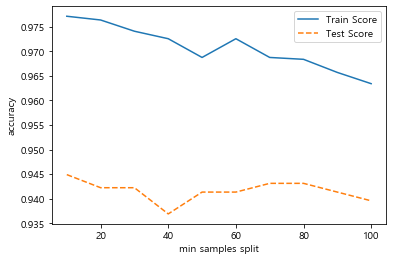

In [16]:
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_accuracy, linestyle = "--", label = "Test Score")
plt.ylabel("accuracy"); plt.xlabel("min samples split")
plt.legend()

In [18]:
train_accuracy = []; test_accuracy = []
para_leaf = [n_leaf * 10 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingClassifier(min_samples_leaf = v_min_samples_leaf, max_depth = 4, n_estimators = 100, learning_rate = 0.1, min_samples_split = 10, random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf['TrainAccuracy'] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,10,0.977,0.946
1,20,0.970,0.942
2,30,0.970,0.942
3,40,0.963,0.940
4,50,0.960,0.942
5,60,0.958,0.939
6,70,0.958,0.937
7,80,0.955,0.940
8,90,0.950,0.936
9,100,0.948,0.938


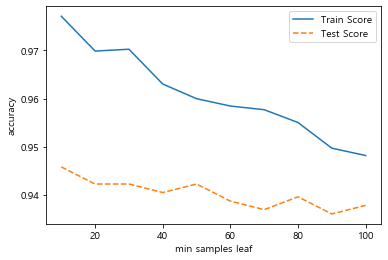

In [19]:
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Score")
plt.plot(para_leaf, test_accuracy, linestyle = "--", label = "Test Score")
plt.ylabel("accuracy"); plt.xlabel("min samples leaf")
plt.legend()

In [20]:
gb_final = GradientBoostingClassifier(random_state = 1234, n_estimators = 100, max_depth = 4, min_samples_leaf = 10, min_samples_split = 10, learning_rate = 0.1)
gb_final.fit(df_train_x, df_train_y)
y_pred = gb_final.predict(df_test_x)
print("Accuracy on training set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(gb_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set: 0.977
Accuracy on test set: 0.946
Confusion matrix: 
[[1018    3]
 [  58   46]]


In [21]:
from sklearn.svm import SVC

In [41]:
svm_uncustomized

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=1234, shrinking=True,
    tol=0.001, verbose=False)

In [22]:
svm_uncustomized = SVC(random_state = 1234)
svm_uncustomized.fit(df_train_x, df_train_y)
print("Scoring on training set: {:.3f}".format(svm_uncustomized.score(df_train_x, df_train_y)))
print("Scoring on test set: {:.3f}".format(svm_uncustomized.score(df_test_x, df_test_y)))

Scoring on training set: 0.908
Scoring on test set: 0.908


In [24]:
train_accuracy = []; test_accuracy = []
para_c = [10**c for c in range(-2, 2)]

for v_c in para_c:
    svm = SVC(C = v_c, random_state = 1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))

df_accuracy_c = pd.DataFrame()
df_accuracy_c["C"] = para_c
df_accuracy_c['TrainAccuracy'] = train_accuracy
df_accuracy_c["TestAccuracy"] = test_accuracy
df_accuracy_c.round(3)

,C,TrainAccuracy,TestAccuracy
0,0.01,0.908,0.908
1,0.10,0.908,0.908
2,1.00,0.908,0.908
3,10.00,0.909,0.908


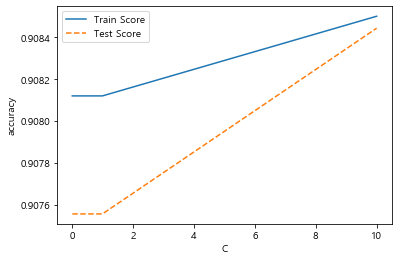

In [25]:
plt.plot(para_c, train_accuracy, linestyle = "-", label = "Train Score")
plt.plot(para_c, test_accuracy, linestyle = "--", label = "Test Score")
plt.ylabel("accuracy"); plt.xlabel("C")
plt.legend()

In [26]:
train_accuracy = []; test_accuracy = []
para_gamma = [10**gamma for gamma in range(-2, 2)]

for v_gamma in para_gamma:
    svm = SVC(gamma = v_gamma, C = 0.1, random_state = 1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))

df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma['TrainAccuracy'] = train_accuracy
df_accuracy_gamma["TestAccuracy"] = test_accuracy
df_accuracy_gamma.round(3)

,gamma,TrainAccuracy,TestAccuracy
0,0.01,0.908,0.908
1,0.10,0.908,0.908
2,1.00,0.908,0.908
3,10.00,0.908,0.908


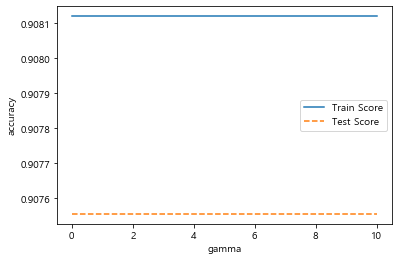

In [27]:
plt.plot(para_gamma, train_accuracy, linestyle = "-", label = "Train Score")
plt.plot(para_gamma, test_accuracy, linestyle = "--", label = "Test Score")
plt.ylabel("accuracy"); plt.xlabel("gamma")
plt.legend()

In [32]:
v_feature_name = df_train_x.columns
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_x)
df_scaled = pd.DataFrame(df_scaled, columns = v_feature_name)
df_scaled.head()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
2,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556
3,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,-1.548549,1.548549,2.618672,-0.446497,-0.828257,-0.574064,-0.131804,-0.189556
4,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556


In [33]:
df_scaled_train_x, df_scaled_test_x =  train_test_split(df_scaled, test_size = 0.3, random_state = 1234)
print("train data x size: {}".format(df_scaled_train_x.shape))
print("train data y size: {}".format(df_scaled_test_x.shape))

train data x size: (2623, 18)
train data y size: (1125, 18)


In [34]:
svm_scaled = SVC(random_state = 1234)
svm_scaled.fit(df_scaled_train_x, df_train_y)
print("Scoring on training set: {:.3f}".format(svm_scaled.score(df_scaled_train_x, df_train_y)))
print("Scoring on test set: {:.3f}".format(svm_scaled.score(df_scaled_test_x, df_test_y)))

Scoring on training set: 0.944
Scoring on test set: 0.935


In [35]:
train_accuracy = []; test_accuracy = []
para_c = [10**c for c in range(-2, 2)]

for v_c in para_c:
    svm = SVC(C = v_c, random_state = 1234)
    svm.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(svm.score(df_scaled_test_x, df_test_y))

df_accuracy_c = pd.DataFrame()
df_accuracy_c["C"] = para_c
df_accuracy_c['TrainAccuracy'] = train_accuracy
df_accuracy_c["TestAccuracy"] = test_accuracy
df_accuracy_c.round(3)

,C,TrainAccuracy,TestAccuracy
0,0.01,0.908,0.908
1,0.10,0.908,0.908
2,1.00,0.944,0.935
3,10.00,0.979,0.949


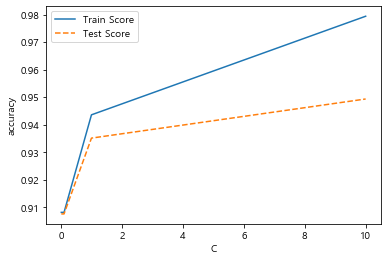

In [36]:
plt.plot(para_c, train_accuracy, linestyle = "-", label = "Train Score")
plt.plot(para_c, test_accuracy, linestyle = "--", label = "Test Score")
plt.ylabel("accuracy"); plt.xlabel("C")
plt.legend()

In [38]:
train_accuracy = []; test_accuracy = []
para_gamma = [10**gamma for gamma in range(-2, 2)]

for v_gamma in para_gamma:
    svm = SVC(gamma = v_gamma, C = 1, random_state = 1234)
    svm.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(svm.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(svm.score(df_scaled_test_x, df_test_y))

df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma['TrainAccuracy'] = train_accuracy
df_accuracy_gamma["TestAccuracy"] = test_accuracy
df_accuracy_gamma.round(3)

,gamma,TrainAccuracy,TestAccuracy
0,0.01,0.923,0.920
1,0.10,0.960,0.942
2,1.00,0.996,0.920
3,10.00,1.000,0.908


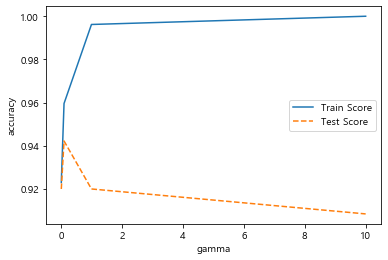

In [39]:
plt.plot(para_gamma, train_accuracy, linestyle = "-", label = "Train Score")
plt.plot(para_gamma, test_accuracy, linestyle = "--", label = "Test Score")
plt.ylabel("accuracy"); plt.xlabel("gamma")
plt.legend()

In [40]:
svc_final = SVC(gamma = 0.1, C =1, random_state = 1234)
svc_final.fit(df_scaled_train_x, df_train_y)
y_pred = svc_final.predict(df_scaled_test_x)
print("Accuracy on training set: {:.3f}".format(svc_final.score(df_scaled_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(svc_final.score(df_scaled_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set: 0.960
Accuracy on test set: 0.942
Confusion matrix: 
[[1021    0]
 [  65   39]]


In [43]:
from sklearn.neural_network import MLPClassifier

In [44]:
df_raw = pd.read_csv("HMEQ.csv")
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [45]:
df_raw.isnull().sum()
df_raw["JOB"].fillna("Other", inplace = True)
df_raw.fillna(df_raw.mean(), inplace = True)
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [46]:
df_y = df_raw_dummy["BAD"]
df_x = df_raw_dummy.drop("BAD", axis = 1, inplace = False)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3, random_state = 1234)
print("train data x size: {}".format(df_train_x.shape))
print("train data y size: {}".format(df_train_y.shape))
print("test data x size: {}".format(df_test_x.shape))
print("test data y size: {}".format(df_test_y.shape))

train data x size: (2623, 18)
train data y size: (2623,)
test data x size: (1125, 18)
test data y size: (1125,)


In [48]:
nn_uncustomized = MLPClassifier(random_state = 1234)
nn_uncustomized.fit(df_train_x, df_train_y)
print("Scoring on training set: {:.3f}".format(nn_uncustomized.score(df_train_x, df_train_y)))
print("Scoring on test set: {:.3f}".format(nn_uncustomized.score(df_test_x, df_test_y)))

Scoring on training set: 0.146
Scoring on test set: 0.150


C:\Users\cptas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [51]:
train_accuracy = []; test_accuracy = []
para_hidden = [20*hidden for hidden in range(1, 9)]

for v_hidden in para_hidden:
    nn = MLPClassifier(hidden_layer_sizes = v_hidden, random_state = 1234)
    nn.fit(df_train_x, df_train_y)
    train_accuracy.append(nn.score(df_train_x, df_train_y))
    test_accuracy.append(nn.score(df_test_x, df_test_y))

df_accuracy_hidden = pd.DataFrame()
df_accuracy_hidden["HiddenLayer"] = para_hidden
df_accuracy_hidden['TrainAccuracy'] = train_accuracy
df_accuracy_hidden["TestAccuracy"] = test_accuracy
df_accuracy_hidden.round(3)

C:\Users\cptas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\cptas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\cptas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\cptas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

,HiddenLayer,TrainAccuracy,TestAccuracy
0,20,0.908,0.908
1,40,0.910,0.913
2,60,0.910,0.910
3,80,0.905,0.905
4,100,0.146,0.150
5,120,0.910,0.909
6,140,0.650,0.629
7,160,0.895,0.890


ValueError: x and y must have same first dimension, but have shapes (8,) and (3,)

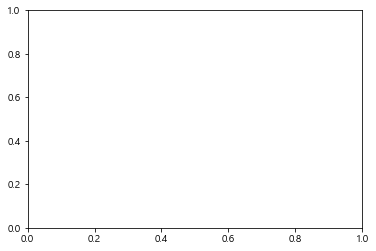

In [54]:
plt.plot(para_hidden, train_accuracy, linestyle = "-", label = "Train Score")
plt.plot(para_hidden, test_accuracy, linestyle = "--", label = "Test Score")
plt.ylabel("accuracy"); plt.xlabel("Hidden Layer")
plt.legend()

In [52]:
train_accuracy = []; test_accuracy = []
para_function = ["logistic", "tanh", "relu"]

for v_function in para_function:
    nn = MLPClassifier(activation = v_function, random_state = 1234)
    nn.fit(df_train_x, df_train_y)
    train_accuracy.append(nn.score(df_train_x, df_train_y))
    test_accuracy.append(nn.score(df_test_x, df_test_y))

df_accuracy_function = pd.DataFrame()
df_accuracy_function["Activation Function"] = para_function
df_accuracy_function['TrainAccuracy'] = train_accuracy
df_accuracy_function["TestAccuracy"] = test_accuracy
df_accuracy_function.round(3)

C:\Users\cptas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,Activation Function,TrainAccuracy,TestAccuracy
0,logistic,0.908,0.908
1,tanh,0.908,0.908
2,relu,0.146,0.150


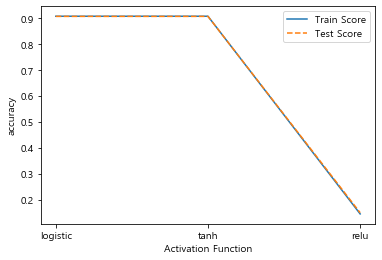

In [53]:
plt.plot(para_function, train_accuracy, linestyle = "-", label = "Train Score")
plt.plot(para_function, test_accuracy, linestyle = "--", label = "Test Score")
plt.ylabel("accuracy"); plt.xlabel("Activation Function")
plt.legend()

In [55]:
v_feature_name = df_train_x.columns
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_x)
df_scaled = pd.DataFrame(df_scaled, columns = v_feature_name)
df_scaled.head()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
2,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556
3,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,-1.548549,1.548549,2.618672,-0.446497,-0.828257,-0.574064,-0.131804,-0.189556
4,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556


In [56]:
df_scaled_train_x, df_scaled_test_x =  train_test_split(df_scaled, test_size = 0.3, random_state = 1234)
print("train data x size: {}".format(df_scaled_train_x.shape))
print("train data y size: {}".format(df_scaled_test_x.shape))

train data x size: (2623, 18)
train data y size: (1125, 18)


In [58]:
nn_scaled = MLPClassifier(random_state = 1234)
nn_scaled.fit(df_scaled_train_x, df_train_y)
print("Scoring on training set: {:.3f}".format(nn_scaled.score(df_scaled_train_x, df_train_y)))
print("Scoring on test set: {:.3f}".format(nn_scaled.score(df_scaled_test_x, df_test_y)))

Scoring on training set: 0.971
Scoring on test set: 0.943


C:\Users\cptas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [59]:
train_accuracy = []; test_accuracy = []
para_hidden = [20*hidden for hidden in range(1, 9)]

for v_hidden in para_hidden:
    nn = MLPClassifier(hidden_layer_sizes = v_hidden, random_state = 1234)
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))

df_accuracy_hidden = pd.DataFrame()
df_accuracy_hidden["HiddenLayer"] = para_hidden
df_accuracy_hidden['TrainAccuracy'] = train_accuracy
df_accuracy_hidden["TestAccuracy"] = test_accuracy
df_accuracy_hidden.round(3)

C:\Users\cptas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\cptas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\cptas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\cptas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

,HiddenLayer,TrainAccuracy,TestAccuracy
0,20,0.952,0.940
1,40,0.962,0.943
2,60,0.970,0.944
3,80,0.969,0.944
4,100,0.971,0.943
5,120,0.975,0.943
6,140,0.977,0.944
7,160,0.979,0.947


In [ ]:
plt.plot(para_hidden, train_accuracy, linestyle = "-", label = "Train Score")
plt.plot(para_hidden, test_accuracy, linestyle = "--", label = "Test Score")
plt.ylabel("accuracy"); plt.xlabel("Hidden Layer")
plt.legend()

In [ ]:
train_accuracy = []; test_accuracy = []
para_function = ["logistic", "tanh", "relu"]

for v_function in para_function:
    nn = MLPClassifier(activation = v_function, random_state = 1234)
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))

df_accuracy_function = pd.DataFrame()
df_accuracy_function["Activation Function"] = para_function
df_accuracy_function['TrainAccuracy'] = train_accuracy
df_accuracy_function["TestAccuracy"] = test_accuracy
df_accuracy_function.round(3)

In [ ]:
plt.plot(para_function, train_accuracy, linestyle = "-", label = "Train Score")
plt.plot(para_function, test_accuracy, linestyle = "--", label = "Test Score")
plt.ylabel("accuracy"); plt.xlabel("Activation Function")
plt.legend()

In [60]:
train_accuracy = []; test_accuracy = []
para_solver = ["lbfgs", "sgd", "adam"]

for v_solver in para_solver:
    nn = MLPClassifier(solver = v_solver, activation = "relu", hidden_layer_sizes = (80, 80), random_state = 1234)
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))

df_accuracy_solver = pd.DataFrame()
df_accuracy_solver["Solver"] = para_solver
df_accuracy_solver['TrainAccuracy'] = train_accuracy
df_accuracy_solver["TestAccuracy"] = test_accuracy
df_accuracy_solver.round(3)

C:\Users\cptas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\cptas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


,Solver,TrainAccuracy,TestAccuracy
0,lbfgs,1.000,0.948
1,sgd,0.934,0.928
2,adam,1.000,0.955


In [ ]:
plt.plot(para_solver, train_accuracy, linestyle = "-", label = "Train Score")
plt.plot(para_solver, test_accuracy, linestyle = "--", label = "Test Score")
plt.ylabel("accuracy"); plt.xlabel("Solver")
plt.legend()

In [62]:
train_accuracy = []; test_accuracy = []
para_batch = [20*batch for batch in range(1, 10)]

for v_batch in para_batch:
    nn = MLPClassifier(batch_size = v_batch, solver = "adam", activation = "relu", hidden_layer_sizes = (80, 80), random_state = 1234)
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))

df_accuracy_batch = pd.DataFrame()
df_accuracy_batch["Mini Batch"] = para_batch
df_accuracy_batch['TrainAccuracy'] = train_accuracy
df_accuracy_batch["TestAccuracy"] = test_accuracy
df_accuracy_batch.round(3)

C:\Users\cptas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\cptas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\cptas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\cptas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

,Mini Batch,TrainAccuracy,TestAccuracy
0,20,1.0,0.959
1,40,1.0,0.956
2,60,1.0,0.950
3,80,1.0,0.952
4,100,1.0,0.952
5,120,1.0,0.953
6,140,1.0,0.953
7,160,1.0,0.954
8,180,1.0,0.956


In [ ]:
plt.plot(para_batch, train_accuracy, linestyle = "-", label = "Train Score")
plt.plot(para_batch, test_accuracy, linestyle = "--", label = "Test Score")
plt.ylabel("accuracy"); plt.xlabel("Mini Batch Size")
plt.legend()

In [ ]:
nn_final = MLPClassifier(batch_size = 100, solver = "adam", activation = "relu", hidden_layer_sizes = (80, 80),random_state = 1234)
nn_final.fit(df_scaled_train_x, df_train_y)
y_pred = nn_final.predict(df_scaled_test_x)
print("Scoring on training set: {:.3f}".format(nn_final.score(df_scaled_train_x, df_train_y)))
print("Scoring on test set: {:.3f}".format(nn_final.score(df_scaled_test_x, df_test_y)))
print)"Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred))